# Вариант: Список людей.
ссылка на датасет: https://www.kaggle.com/datasets/imoore/age-dataset

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    precision_score, recall_score, accuracy_score, roc_auc_score, f1_score,
    matthews_corrcoef, cohen_kappa_score, confusion_matrix
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score

# Функция для применения oversampling
def apply_oversampling(X, y):
    oversampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    return X_resampled, y_resampled

# Функция для применения undersampling
def apply_undersampling(X, y):
    undersampler = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(X, y)
    return X_resampled, y_resampled

def split_stratified_into_train_val_test(
    df_input,
    stratify_colname="y",
    frac_train=0.6,
    frac_val=0.15,
    frac_test=0.25,
    random_state=None,
):

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError(
            "fractions %f, %f, %f do not add up to 1.0"
            % (frac_train, frac_val, frac_test)
        )

    if stratify_colname not in df_input.columns:
        raise ValueError("%s is not a column in the dataframe" % (stratify_colname))

    X = df_input  # Contains all columns.
    y = df_input[
        [stratify_colname]
    ]  # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(
        X, y, stratify=y, test_size=(1.0 - frac_train), random_state=random_state
    )

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(
        df_temp,
        y_temp,
        stratify=y_temp,
        test_size=relative_frac_test,
        random_state=random_state,
    )

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test


df = pd.read_csv("../static/csv/AgeDataset-V1.csv", nrows=1000)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 1000 non-null   object 
 1   Name               1000 non-null   object 
 2   Short description  1000 non-null   object 
 3   Gender             995 non-null    object 
 4   Country            962 non-null    object 
 5   Occupation         998 non-null    object 
 6   Birth year         1000 non-null   int64  
 7   Death year         999 non-null    float64
 8   Manner of death    372 non-null    object 
 9   Age of death       999 non-null    float64
dtypes: float64(2), int64(1), object(7)
memory usage: 78.3+ KB


Как бизнес-цели выделим следующие 2 варианта: 1) GameDev. Создание игры про конкретного персонажа, живущего в конкретном временном промежутке в конкретной стране. 2) Классификация людей по возрастным группам, что может быть полезно для рекламных целей


Выполним подготовку данных



In [6]:
df.fillna({"Gender": "NaN", "Country": "NaN", "Occupation" : "NaN", "Manner of death" : "NaN"}, inplace=True)
df = df.dropna()
df['Country'] = df['Country'].str.split('; ')
df = df.explode('Country')
data = df.copy()


value_counts = data["Country"].value_counts()
rare = value_counts[value_counts < 100].index
data = data[~data["Country"].isin(rare)]

data.drop(data[~data['Gender'].isin(['Male', 'Female'])].index, inplace=True)

data1 = pd.get_dummies(data, columns=['Gender', 'Country', 'Occupation'], drop_first=True)

Определить достижимый уровень качества модели для каждой задачи. На основе имеющихся данных уровень качества моделей не будет высоким, поскольку все таки длительность жизни лишь примерная и точно ее угадать невозможно.

Выберем ориентиры для наших 2х задач: 1)Регрессии - средний возраст человека 2)Классификации - аиболее часто встречающаяся возрастная группа

Построим конвейер.

In [7]:
print(data.columns)

Index(['Id', 'Name', 'Short description', 'Gender', 'Country', 'Occupation',
       'Birth year', 'Death year', 'Manner of death', 'Age of death'],
      dtype='object')


In [8]:
X_reg = data1.drop(['Id', 'Name', 'Age of death', 'Short description', 'Manner of death'], axis=1)
y_reg = data1['Age of death']

# Разделение данных
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Выбор моделей для регрессии
models_reg = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42)
}

# Создание конвейера для регрессии
pipelines_reg = {}
for name, model in models_reg.items():
    pipelines_reg[name] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

# Определение сетки гиперпараметров для регрессии
param_grids_reg = {
    'Linear Regression': {},
    'Random Forest Regressor': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30]
    },
    'Gradient Boosting Regressor': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
}

# Настройка гиперпараметров для регрессии
best_models_reg = {}
for name, pipeline in pipelines_reg.items():
    grid_search = GridSearchCV(pipeline, param_grids_reg[name], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_reg, y_train_reg)
    best_models_reg[name] = grid_search.best_estimator_
    print(f'Best parameters for {name}: {grid_search.best_params_}')


Best parameters for Linear Regression: {}
Best parameters for Random Forest Regressor: {'model__max_depth': None, 'model__n_estimators': 200}
Best parameters for Gradient Boosting Regressor: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 300}


In [9]:
# Обучение моделей и оценка качества
results_reg = {}

for model_name in best_models_reg.keys():
    print(f"Model: {model_name}")
    model_pipeline = best_models_reg[model_name]

    y_train_predict = model_pipeline.predict(X_train_reg)
    y_test_predict = model_pipeline.predict(X_test_reg)

    results_reg[model_name] = {
        "pipeline": model_pipeline,
        "preds_train": y_train_predict,
        "preds_test": y_test_predict,
        "MSE_train": mean_squared_error(y_train_reg, y_train_predict),
        "MSE_test": mean_squared_error(y_test_reg, y_test_predict),
        "R2_train": r2_score(y_train_reg, y_train_predict),
        "R2_test": r2_score(y_test_reg, y_test_predict),
        "MAE_train": mean_absolute_error(y_train_reg, y_train_predict),
        "MAE_test": mean_absolute_error(y_test_reg, y_test_predict),
    }

# Теперь результаты каждой модели находятся в results_reg
print(results_reg)


Model: Linear Regression
Model: Random Forest Regressor
Model: Gradient Boosting Regressor
{'Linear Regression': {'pipeline': Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())]), 'preds_train': array([29., 53., 82., 55., 62., 42., 21., 75., 52., 32., 36., 73., 37.,
       46., 72., 27., 71., 83., 55., 22., 65., 47., 57., 78., 91., 60.,
       72., 67., 61., 88., 60., 88., 91., 52., 84., 93., 44., 58., 90.,
       94., 59., 92., 84., 64., 51., 93., 79., 81., 72., 78., 74., 27.,
       92., 46., 72., 78., 96., 95., 77., 49., 87., 90., 88., 88., 65.,
       42., 74., 87., 41., 77., 92., 69., 94., 49., 85., 79., 73., 43.,
       55., 73., 51., 79., 52., 63., 60., 68., 70., 39., 59., 79., 27.,
       57., 78., 80., 19., 69., 68., 39., 60., 67., 68., 87., 81., 62.,
       73., 23., 69., 67., 47., 45., 90., 82., 87., 70., 77., 67., 66.,
       84., 64., 54., 46., 75., 84., 36., 72., 42., 52., 48., 55., 89.,
       64., 80., 28., 52., 81., 63., 74., 68., 53., 66., 36.

In [10]:
data2 = data.drop(['Short description', 'Manner of death', 'Gender', 'Country', 'Occupation'], axis=1)

In [11]:
# Создание возрастных групп
bins = [0, 18, 30, 50, 70, 100]
labels = ['0-18', '19-30', '31-50', '51-70', '71+']
data['Age Group'] = pd.cut(data['Age of death'], bins=bins, labels=labels)
data2['Age Group'] = pd.cut(data2['Age of death'], bins=bins, labels=labels)

# Выбор признаков и целевой переменной для классификации
X_class = data2.drop(['Id', 'Name', 'Age of death', 'Age Group'], axis=1)
y_class = data['Age Group']  
print(X_class.columns)
# Разделение данных
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Выбор моделей для классификации
models_class = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=5000, solver='liblinear'),
    'Random Forest Classifier': RandomForestClassifier(random_state=42),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42)
}

# Создание конвейера для классификации
pipelines_class = {}
for name, model in models_class.items():
    pipelines_class[name] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

# Определение сетки гиперпараметров для классификации

param_grids_class = {
    'Logistic Regression': {
        'model__C': [0.1, 1, 10],
        'model__solver': ['lbfgs', 'liblinear']
    },
    'Random Forest Classifier': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30]
    },
    'Gradient Boosting Classifier': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
}
# Убрал определение параметров поскольку уже был предподсчет данных, но вылетела ошибка. Сохранил лучшие параметры

param_grids_class = {
    'Logistic Regression': {
        'model__C': [10],
        'model__solver': ['lbfgs']
    },
    'Random Forest Classifier': {
        'model__n_estimators': [200],
        'model__max_depth': [ 30]
    },
    'Gradient Boosting Classifier': {
        'model__n_estimators': [200],
        'model__learning_rate': [0.1],
        'model__max_depth': [7]
    }
}

# Настройка гиперпараметров для классификации
best_models_class = {}
for name, pipeline in pipelines_class.items():
    grid_search = GridSearchCV(pipeline, param_grids_class[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_class, y_train_class)
    best_models_class[name] = {"model": grid_search.best_estimator_}
    print(f'Best parameters for {name}: {grid_search.best_params_}')

# Обучение моделей и оценка качества
for model_name in best_models_class.keys():
    print(f"Model: {model_name}")
    model = best_models_class[model_name]["model"]

    model_pipeline = Pipeline([("scaler", StandardScaler()), ("model", model)])
    model_pipeline = model_pipeline.fit(X_train_class, y_train_class)

    y_train_predict = model_pipeline.predict(X_train_class)
    y_test_probs = model_pipeline.predict_proba(X_test_class)
    y_test_predict = model_pipeline.predict(X_test_class)

    best_models_class[model_name]["pipeline"] = model_pipeline
    best_models_class[model_name]["probs"] = y_test_probs
    best_models_class[model_name]["preds"] = y_test_predict

    best_models_class[model_name]["Precision_train"] = precision_score(y_train_class, y_train_predict, average='weighted')
    best_models_class[model_name]["Precision_test"] = precision_score(y_test_class, y_test_predict, average='weighted')
    best_models_class[model_name]["Recall_train"] = recall_score(y_train_class, y_train_predict, average='weighted')
    best_models_class[model_name]["Recall_test"] = recall_score(y_test_class, y_test_predict, average='weighted')
    best_models_class[model_name]["Accuracy_train"] = accuracy_score(y_train_class, y_train_predict)
    best_models_class[model_name]["Accuracy_test"] = accuracy_score(y_test_class, y_test_predict)
    best_models_class[model_name]["ROC_AUC_test"] = roc_auc_score(y_test_class, y_test_probs, multi_class='ovr')
    best_models_class[model_name]["F1_train"] = f1_score(y_train_class, y_train_predict, average='weighted')
    best_models_class[model_name]["F1_test"] = f1_score(y_test_class, y_test_predict, average='weighted')
    best_models_class[model_name]["MCC_test"] = matthews_corrcoef(y_test_class, y_test_predict)
    best_models_class[model_name]["Cohen_kappa_test"] = cohen_kappa_score(y_test_class, y_test_predict)
    best_models_class[model_name]["Confusion_matrix"] = confusion_matrix(y_test_class, y_test_predict)

Index(['Birth year', 'Death year'], dtype='object')
Best parameters for Logistic Regression: {'model__C': 10, 'model__solver': 'lbfgs'}
Best parameters for Random Forest Classifier: {'model__max_depth': 30, 'model__n_estimators': 200}
Best parameters for Gradient Boosting Classifier: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200}
Model: Logistic Regression
Model: Random Forest Classifier


c:\Users\alexk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alexk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: Gradient Boosting Classifier


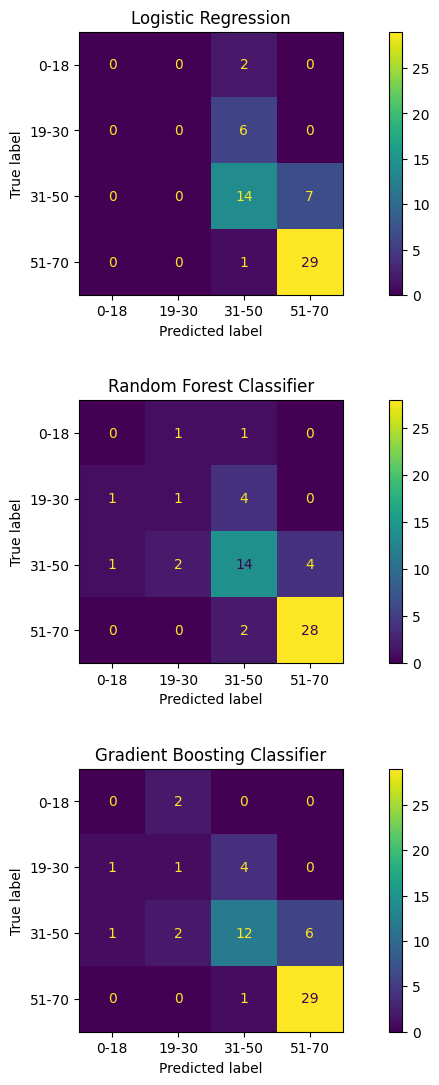

In [12]:
num_models = len(best_models_class)
fig, ax = plt.subplots(num_models, 1, figsize=(12, 10), sharex=False, sharey=False)

for index, key in enumerate(best_models_class.keys()):
    c_matrix = best_models_class[key]["Confusion_matrix"]
    
    # Получаем метки классов из матрицы ошибок
    num_classes = c_matrix.shape[0]
    actual_labels = ["0-18", "19-30", "31-50", "51-70", "71+"][:num_classes]
    
    disp = ConfusionMatrixDisplay(
        confusion_matrix=c_matrix, display_labels=actual_labels
    ).plot(ax=ax.flat[index])
    disp.ax_.set_title(key)

plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.1)
plt.show()


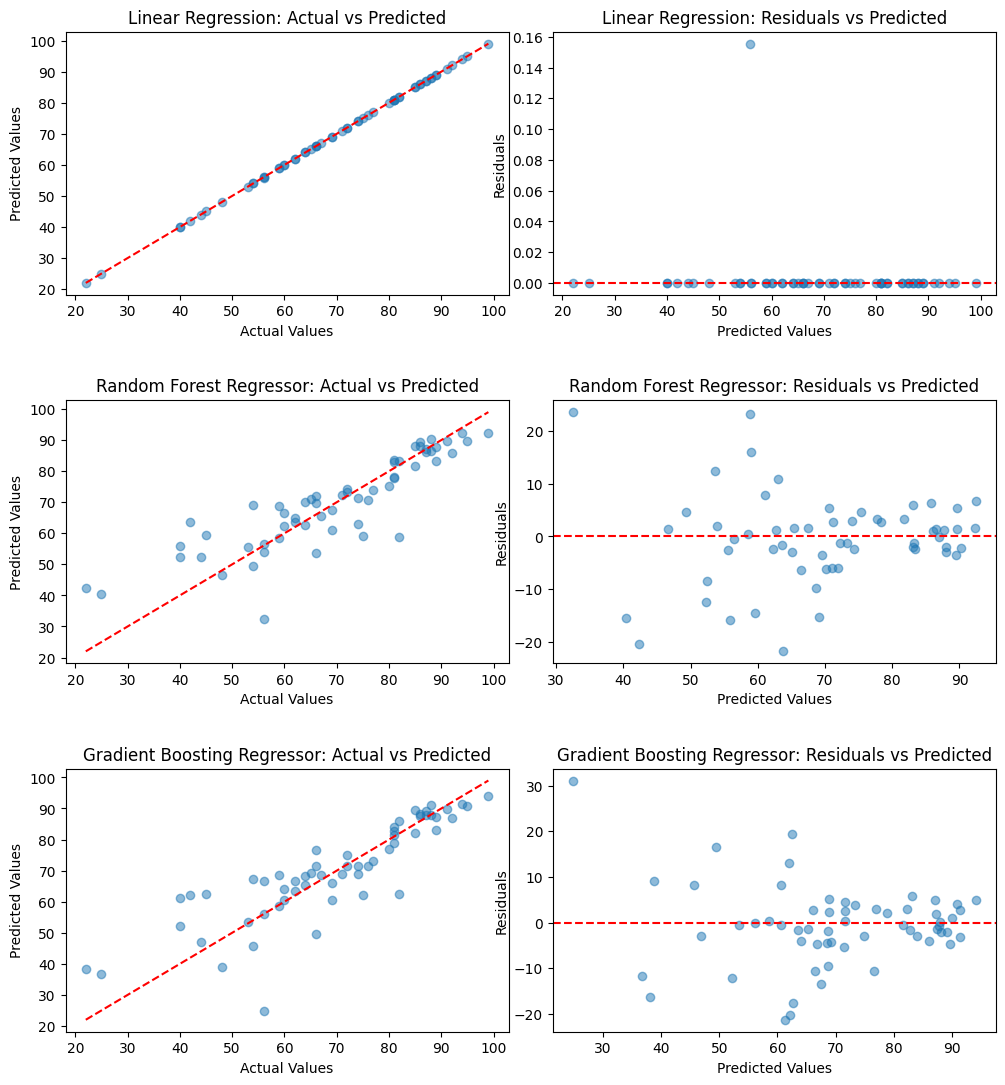

In [13]:
_, ax = plt.subplots(3, 2, figsize=(12, 10), sharex=False, sharey=False)
ax = ax.flatten()

for index, (name, model) in enumerate(best_models_reg.items()):
    y_pred_reg = model.predict(X_test_reg)

    # График фактических значений против предсказанных значений
    ax[index * 2].scatter(y_test_reg, y_pred_reg, alpha=0.5)
    ax[index * 2].plot([min(y_test_reg), max(y_test_reg)], [min(y_test_reg), max(y_test_reg)], color='red', linestyle='--')
    ax[index * 2].set_xlabel('Actual Values')
    ax[index * 2].set_ylabel('Predicted Values')
    ax[index * 2].set_title(f'{name}: Actual vs Predicted')

    # График остатков
    residuals = y_test_reg - y_pred_reg
    ax[index * 2 + 1].scatter(y_pred_reg, residuals, alpha=0.5)
    ax[index * 2 + 1].axhline(y=0, color='red', linestyle='--')
    ax[index * 2 + 1].set_xlabel('Predicted Values')
    ax[index * 2 + 1].set_ylabel('Residuals')
    ax[index * 2 + 1].set_title(f'{name}: Residuals vs Predicted')


plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.1)
plt.show()